In [1]:
import astropy.units as u
from astropy.utils import data
from spectral_cube import SpectralCube
import matplotlib.pyplot as plt 
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
from tqdm import tqdm
%matplotlib inline

In [2]:
import warnings; warnings.filterwarnings('ignore')
from astropy import constants as const
import matplotlib.pyplot as plt
from photutils.aperture import CircularAperture
import photutils
from photutils import aperture_photometry
from photutils.isophote import Ellipse
from photutils.isophote import EllipseGeometry
from matplotlib.colors import LogNorm

plt.rc('axes', lw = 2)
plt.rc('font', family = 'serif')

In [3]:
filename = './GALFA_HI_RA+DEC_076.00+26.35_N.fits'
cube = SpectralCube.read(filename).spectral_slab(-40 * u.km/u.s, 35 * u.km/u.s)
cube = cube.with_spectral_unit(u.km / u.s)
moment0 = cube.moment(order = 0)
#

In [26]:
cube

SpectralCube with shape=(409, 512, 512):
 n_x:    512  type_x: RA        unit_x: deg    range:    71.741658 deg:   80.258342 deg
 n_y:    512  type_y: DEC       unit_y: deg    range:    22.091658 deg:   30.608342 deg
 n_s:    409  type_s: VOPT      unit_s: km / s  range:      -40.027 km / s:      35.058 km / s

In [4]:
ON_x = 271
ON_y = 190
aprad = 3.25
sep = 8

positions = [(ON_x, ON_y), (ON_x + sep, ON_y + sep), (ON_x -sep, ON_y - sep), (ON_x + sep, ON_y - sep), (ON_x - sep, ON_y + sep)]
aperturelist = CircularAperture(positions, r= aprad)

Tc = 52.2 
v = []
b = []
for i in tqdm(range(cube.shape[0])):
    channel = cube[i]
    on = aperture_photometry(channel, aperturelist[0])['aperture_sum'].value[0] / (np.pi * aprad**2)
    off1 = aperture_photometry(channel, aperturelist[1])['aperture_sum'].value[0] / (np.pi * aprad**2)
    off2 = aperture_photometry(channel, aperturelist[2])['aperture_sum'].value[0] / (np.pi * aprad**2)
    off3 = aperture_photometry(channel, aperturelist[3])['aperture_sum'].value[0] / (np.pi * aprad**2)
    off4 = aperture_photometry(channel, aperturelist[4])['aperture_sum'].value[0] / (np.pi * aprad**2)
    off = (0.25) * (off1 + off2 + off3 + off4)
    b.append(on)
    
    val = -np.log((on - off)/Tc +1)
    v.append(val)
    del channel

100%|█████████████████████████████████████████| 409/409 [00:05<00:00, 74.00it/s]


[(<matplotlib.patches.Circle at 0x14ceb9b9ef70>,),
 (<matplotlib.patches.Circle at 0x14ceb9ba3040>,),
 (<matplotlib.patches.Circle at 0x14ceb9ba3190>,),
 (<matplotlib.patches.Circle at 0x14ceb9ba32b0>,)]

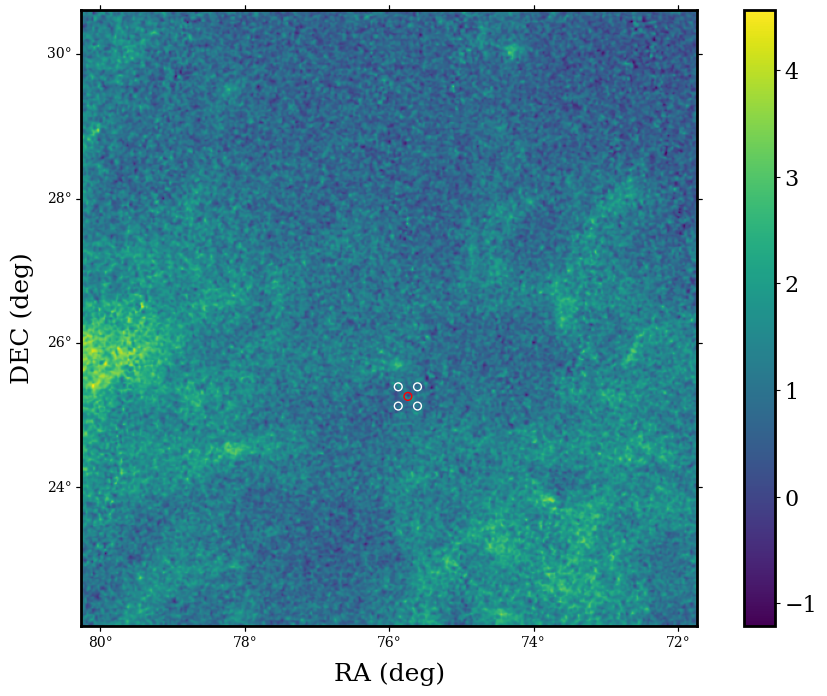

In [5]:
plt.figure(figsize = (12,8))
ax = plt.subplot(111, projection=cube.wcs.celestial)
plt.imshow(cube.hdu.data[345,:,:])
cb = plt.colorbar()
ax.set_xlabel('RA (deg)', fontsize = 18)
ax.set_ylabel('DEC (deg)', fontsize = 18)

for l in cb.ax.yaxis.get_ticklabels():
    l.set_fontsize(16)
for axc in ax.coords: axc.set_format_unit('deg', decimal = True) 
    
aperturelist[0].plot(color = 'red')
[a.plot(color = 'white') for a in aperturelist[1:]]

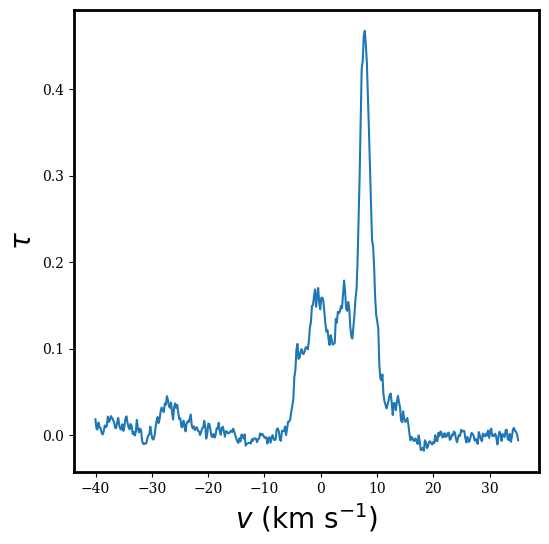

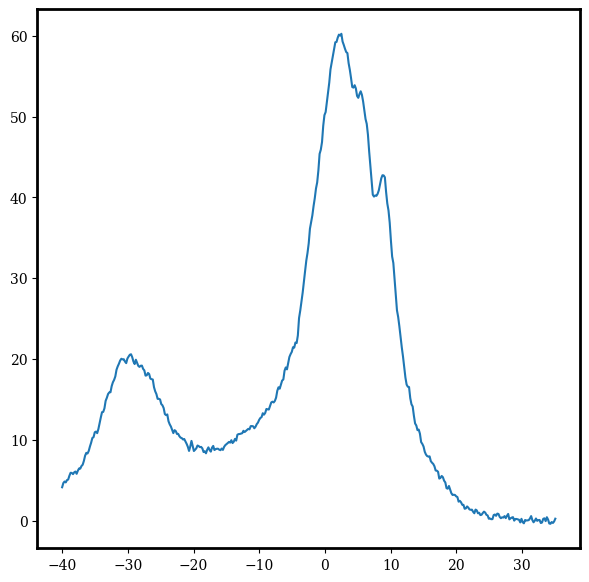

In [6]:
plt.figure(figsize = (6,6))
plt.plot(cube.spectral_axis, np.asarray(v))
plt.ylabel(r'$\tau$', fontsize = 20)
plt.xlabel(r'$v \ (\rm km \ s^{-1})$', fontsize = 20)
ax.tick_params(which = 'both', direction = 'in')

fig=plt.figure(figsize=(7,7))
plt.plot(cube.spectral_axis, b)

In [7]:
import numpy as np
from scipy.optimize import curve_fit

def FIVE_gaussians(x, *params):

    a1, b1, c1, a2, b2, c2, a3, b3, c3, a4, b4, c4, a5, b5, c5 = params
    
    return (a1*np.exp(-(x-b1)**2/(2*c1**2)) + 
            a2*np.exp(-(x-b2)**2/(2*c2**2)) +
            a3*np.exp(-(x-b3)**2/(2*c3**2)) +
            a4*np.exp(-(x-b4)**2/(2*c4**2)) +
            a5*np.exp(-(x-b5)**2/(2*c5**2)))


def fit_FIVE_gaussians(x_data, y_data):
    p0 = [0.1,-25,1,1,1,1,0,1,1,1,1,1,1,1,1]
    popt, pcov = curve_fit(FIVE_gaussians, x_data, y_data, p0=p0, maxfev = 25000,
    bounds = ([0,-35,0,0,-50,0,0,-50,0,0,-50,0,0,-50,0],[0.1,-15,6,50,50,6,50,50,5,50,50,5,50,50,5]))
            
    return popt


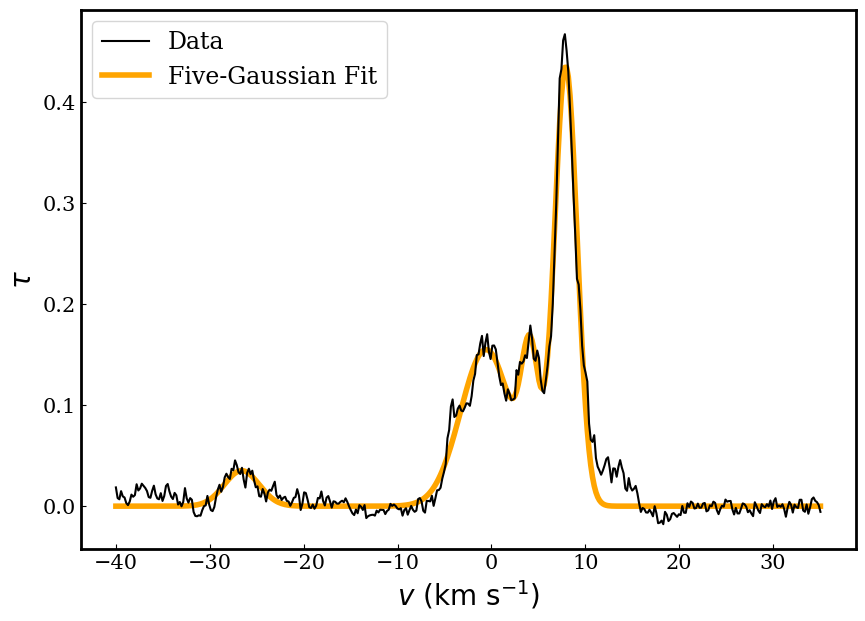

In [8]:
plt.figure(figsize = (10,7))
ax = plt.gca()
ax.plot(cube.spectral_axis, np.asarray(v), color= 'black', 
        label = 'Data')
plt.ylabel(r'$\tau$', fontsize = 20)
plt.xlabel(r'$v \ (\rm km \ s^{-1})$', fontsize = 20)
ax.tick_params(which = 'both', direction = 'in', labelsize = 15)

coeffs = fit_FIVE_gaussians(cube.spectral_axis.value, np.asarray(v))

y = FIVE_gaussians(cube.spectral_axis.value, *coeffs)

ax.plot(cube.spectral_axis.value,y, color = 'orange', lw = 4, alpha = 1, zorder = -1, 
        label = 'Five-Gaussian Fit')
plt.legend(loc = 'upper left', fontsize = 17)
plt.savefig('DecomposedOpticalDepth.pdf',bbox_inches = 'tight')

In [21]:
from scipy.signal import argrelmax

In [22]:
argrelmax(y)

(array([ 73, 214, 239, 261]),)

In [24]:
cube.spectral_axis[argrelmax(y)]

<Quantity [-26.59243758,  -0.64410748,   3.95666026,   8.00533588] km / s>

In [25]:
y[argrelmax(y)] ## PEAK TAU

array([0.03514725, 0.15496315, 0.16953161, 0.43435741])

In [28]:
coeffs[2::3]

array([1.85751061, 0.92790915, 2.7008098 , 1.22162755, 0.01209226])

In [30]:
coeffs[1::3]

array([-26.61809817,   4.12209444,  -0.58664949,   7.92041401,
        -8.64457307])

In [31]:
coeffs[0::3]

array([3.51506013e-02, 1.31703501e-01, 1.54997974e-01, 4.34401680e-01,
       7.63006876e-11])